In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import laspy
import open3d as o3d
import plotly.graph_objs as go
import geopandas as gpd
from scipy.spatial.transform import Rotation as R0

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Panorama images

In [2]:
images_folder = 'data/PANO_21_17/'
lidar_folder = 'data/LAS_21_17/'

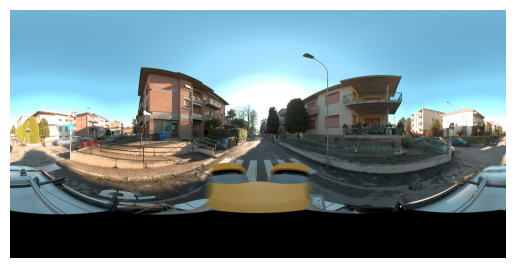

In [3]:
# Load an image
image_path = images_folder + os.listdir(images_folder)[0]
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axes
plt.show()

### Point clouds

Import las files and explore data

In [4]:
def load_las_points(las_file_path):
    las_data = laspy.read(las_file_path)
    points = np.vstack((las_data.x, las_data.y, las_data.z)).transpose()
    colors = np.vstack((las_data.red, las_data.green, las_data.blue)).transpose() / 65535.0 # it is a 16 bit value and that is the maximum
    return points, colors

In [5]:
# Load .las files and process them
las_file_path_1 = lidar_folder + os.listdir(lidar_folder)[0]
las_file_path_2 = lidar_folder + os.listdir(lidar_folder)[1]

points1, colors1 = load_las_points(las_file_path_1)
points2, colors2 = load_las_points(las_file_path_2)

combined_points = np.vstack((points1, points2))
combined_colors = np.vstack((colors1, colors2))

In [6]:
las_data = laspy.read(las_file_path_1)

In [7]:
list(las_data.point_format.dimension_names)

['X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'synthetic',
 'key_point',
 'withheld',
 'overlap',
 'scanner_channel',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'user_data',
 'scan_angle',
 'point_source_id',
 'gps_time',
 'red',
 'green',
 'blue']

X, Y, Z, intensity, red, green and blue are the only dimensions with data in them

Create point cloud using points and colors. Work with it by visualizing it both with colors and with respect to height

In [8]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(combined_points)
pcd.colors = o3d.utility.Vector3dVector(combined_colors)

In [9]:
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

In [10]:
def visualize_with_original_colors(pcd, colors):
    pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.visualization.draw_geometries([pcd])

In [11]:
visualize_with_original_colors(pcd, combined_colors)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [10]:
pcd_downsampled = pcd.voxel_down_sample(voxel_size=0.1)
combined_points_downsampled = np.asarray(pcd_downsampled.points).copy()
combined_colors_downsampled = np.asarray(pcd_downsampled.colors).copy()

In [164]:
visualize_with_original_colors(pcd_downsampled, combined_colors_downsampled)

In [11]:
def color_points_by_height(pcd):
    points = np.asarray(pcd.points)
    z_values = points[:, 2]
    # Normalize z values to [0, 1]
    z_min = np.min(z_values)
    z_max = np.max(z_values)
    z_normalized = (z_values - z_min) / (z_max - z_min)
    # Apply a colormap
    colors = plt.get_cmap("viridis")(z_normalized)[:, :3]
    pcd.colors = o3d.utility.Vector3dVector(colors)

In [12]:
def visualize_color_coded_by_height(pcd):
    color_points_by_height(pcd)
    o3d.visualization.draw_geometries([pcd])

In [162]:
visualize_color_coded_by_height(pcd_downsampled)

In [13]:
pcd_downsampled.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

In [14]:
pcd_downsampled.normals[0]

array([ 0.01622479,  0.87421869, -0.4852612 ])

In [28]:
o3d.visualization.draw_geometries([pcd_downsampled])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [15]:
def segment_plane(pcd, distance_threshold=0.1, ransac_n=3, num_iterations=1000):
    plane_model, inliers = pcd.segment_plane(distance_threshold=distance_threshold,
                                             ransac_n=ransac_n,
                                             num_iterations=num_iterations)
    inlier_cloud = pcd.select_by_index(inliers)
    outlier_cloud = pcd.select_by_index(inliers, invert=True)
    return inlier_cloud, outlier_cloud

In [16]:
plane, others = segment_plane(pcd_downsampled)

In [17]:
o3d.visualization.draw_geometries([plane])

In [19]:
def cluster_and_color(pcd, eps=0.2, min_points=100): # epsilon defines the distance to neighbors in a cluster
    labels = np.array(pcd.cluster_dbscan(eps=eps, min_points=min_points, print_progress=True))
    max_label = labels.max()
    print(f"point cloud has {max_label + 1} clusters")

    # Generate a color for each cluster
    colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
    colors[labels < 0] = 0  # Noise points are assigned color black

    # Assign colors to the point cloud
    pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
    return pcd

In [26]:
# Perform clustering and color the points
colored_pcd = cluster_and_color(pcd, eps=0.3, min_points=100)

point cloud has 1545 clusters


In [27]:
o3d.visualization.draw_geometries([colored_pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
